# Convolution Neural Network 

In [15]:

# import the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, log_loss, matthews_corrcoef, balanced_accuracy_score, 
                             cohen_kappa_score, confusion_matrix)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Reshape
from tensorflow.keras.callbacks import EarlyStopping


In [16]:
df = pd.read_csv('dataset.csv')

C:\Users\raksh\AppData\Local\Temp\ipykernel_15812\112859877.py:1: DtypeWarning: Columns (22,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dataset.csv')


In [17]:
if 'DTC_NUMBER' in df.columns:
    df['DTC_NUMBER'] = df['DTC_NUMBER'].fillna('MIL is OFF0 codes')
    df['EngineHealth'] = df['DTC_NUMBER'].apply(lambda x: 0 if x.strip() == 'MIL is OFF0 codes' else 1)
    print("Created 'EngineHealth' column based on DTC_NUMBER.")
else:
    raise ValueError("DTC_NUMBER column not found in the dataset. Cannot create EngineHealth target.")

Created 'EngineHealth' column based on DTC_NUMBER.


In [18]:
cols_to_drop = [
    'AUTOMATIC', 'BAROMETRIC_PRESSURE(KPA)', 'FUEL_LEVEL', 'AMBIENT_AIR_TEMP', 
    'INTAKE_MANIFOLD_PRESSURE', 'MAF', 'LONG TERM FUEL TRIM BANK 2', 'FUEL_TYPE', 
    'FUEL_PRESSURE', 'SHORT TERM FUEL TRIM BANK 2', 'ENGINE_RUNTIME', 'TROUBLE_CODES', 
    'EQUIV_RATIO', 'TIMESTAMP', 'VEHICLE_ID', 'DTC_NUMBER'
]
df.drop(columns=cols_to_drop, errors='ignore', inplace=True)

In [21]:
feature_cols = [
    'MARK', 'MODEL', 'CAR_YEAR', 'ENGINE_POWER', 'ENGINE_COOLANT_TEMP', 
    'ENGINE_LOAD', 'ENGINE_RPM', 'AIR_INTAKE_TEMP', 'SPEED', 
    'SHORT TERM FUEL TRIM BANK 1', 'THROTTLE_POS', 
    'TIMING_ADVANCE', 'MIN', 'HOURS', 'DAYS_OF_WEEK', 'MONTHS', 'YEAR'
]

In [22]:
df_model = df[feature_cols + ['EngineHealth']].copy()
df_model.dropna(subset=['EngineHealth'], inplace=True)  # Drop rows with missing target

In [23]:
X = df_model[feature_cols]
y = df_model['EngineHealth']

In [24]:
# Preprocessing Pipeline
categorical_features = ['MARK', 'MODEL']
numeric_features = [col for col in feature_cols if col not in categorical_features]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [25]:
#  Split into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# For CNNs, reshape data to add a channel dimension: (samples, timesteps, channels).
input_dim = X_train_processed.shape[1]
X_train_cnn = np.expand_dims(X_train_processed, axis=-1)  # shape: (n_samples, input_dim, 1)
X_test_cnn = np.expand_dims(X_test_processed, axis=-1)
print(f"X_train_cnn shape: {X_train_cnn.shape}")
print(f"X_test_cnn shape: {X_test_cnn.shape}")

X_train_cnn shape: (38011, 38, 1)
X_test_cnn shape: (9503, 38, 1)


### Building the CNN model

In [27]:

model_cnn = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(input_dim, 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification
])

model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


#### Train the Model

In [28]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_cnn = model_cnn.fit(
    X_train_cnn, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

Epoch 1/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9718 - loss: 0.0823 - val_accuracy: 0.9996 - val_loss: 0.0035
Epoch 2/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9997 - loss: 0.0033 - val_accuracy: 0.9997 - val_loss: 0.0016
Epoch 3/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9995 - loss: 0.0027 - val_accuracy: 0.9995 - val_loss: 0.0018
Epoch 4/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9999 - loss: 7.9188e-04 - val_accuracy: 0.9996 - val_loss: 0.0015
Epoch 5/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9996 - loss: 0.0022 - val_accuracy: 0.9995 - val_loss: 0.0032
Epoch 6/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9997 - loss: 0.0012 - val_accuracy: 0.9995 - val_loss: 0.0019
Epoch 7/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9999 - loss: 7.6297e-04 - val_accuracy: 0.9996 - val_loss: 0.0016
Epoch 8/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9994 - loss: 0.0015 - val_accu

### Evaluation of the model

297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9994 - loss: 0.0030
CNN Test Loss: 0.0041, CNN Test Accuracy: 0.9995
297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


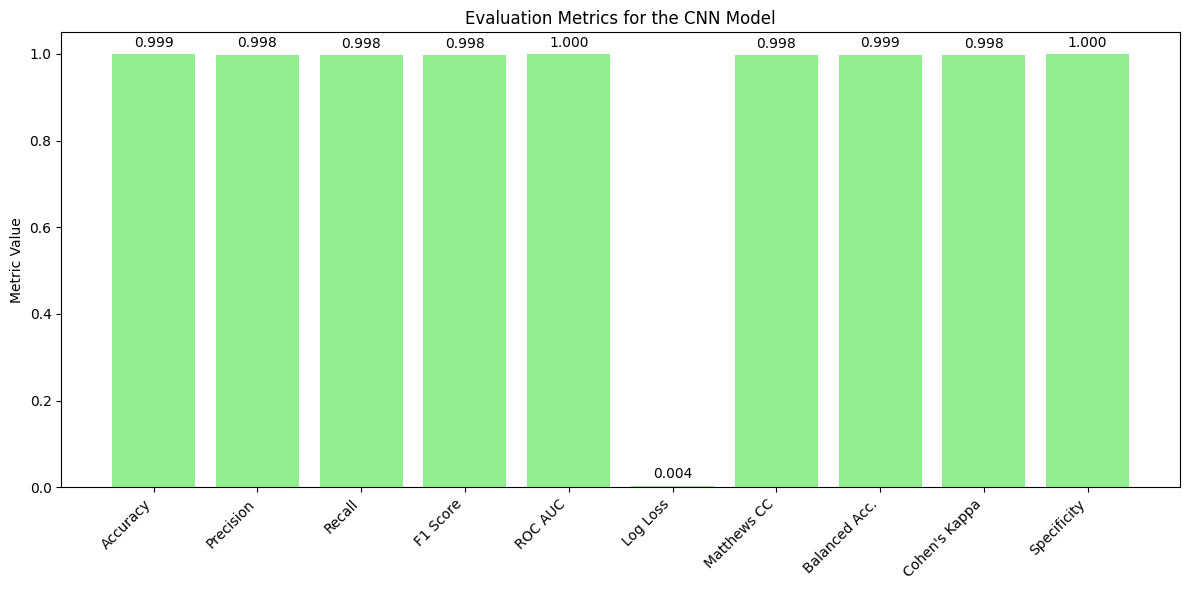

[0 0 0 ... 0 0 0]
[[1.2678505e-09]
 [8.8508427e-09]
 [1.6486799e-08]
 ...
 [1.3277624e-07]
 [5.7571495e-15]
 [2.7634361e-09]]


In [29]:
test_loss_cnn, test_accuracy_cnn = model_cnn.evaluate(X_test_cnn, y_test)
print(f'CNN Test Loss: {test_loss_cnn:.4f}, CNN Test Accuracy: {test_accuracy_cnn:.4f}')
y_pred_proba_cnn = model_cnn.predict(X_test_cnn)
y_pred_cnn = (y_pred_proba_cnn >= 0.5).astype(int).flatten()

# 1. Accuracy
acc = accuracy_score(y_test, y_pred_cnn)
# 2. Precision
prec = precision_score(y_test, y_pred_cnn)
# 3. Recall
rec = recall_score(y_test, y_pred_cnn)
# 4. F1 Score
f1 = f1_score(y_test, y_pred_cnn)
# 5. ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba_cnn)
# 6. Log Loss
ll = log_loss(y_test, y_pred_proba_cnn)
# 7. Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_test, y_pred_cnn)
# 8. Balanced Accuracy
bal_acc = balanced_accuracy_score(y_test, y_pred_cnn)
# 9. Cohen's Kappa Score
kappa = cohen_kappa_score(y_test, y_pred_cnn)
# 10. Specificity (TN / (TN + FP))
cm = confusion_matrix(y_test, y_pred_cnn)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Create a dictionary of metrics for plotting.
metrics_dict_cnn = {
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1 Score": f1,
    "ROC AUC": roc_auc,
    "Log Loss": ll,
    "Matthews CC": mcc,
    "Balanced Acc.": bal_acc,
    "Cohen's Kappa": kappa,
    "Specificity": specificity
}
plt.figure(figsize=(12, 6))
bars = plt.bar(metrics_dict_cnn.keys(), metrics_dict_cnn.values(), color='lightgreen')
plt.title("Evaluation Metrics for the CNN Model")
plt.ylabel("Metric Value")
plt.xticks(rotation=45, ha="right")
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.3f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.tight_layout()
plt.show()
print(y_pred_cnn)
print(y_pred_proba_cnn)